# Reconstruction loss distribution

In [1]:

# Pick an interactive backend. ipympl -> %matplotlib widget if available.
try:
    get_ipython().run_line_magic("matplotlib", "widget")
except Exception:
    try:
        get_ipython().run_line_magic("matplotlib", "notebook")
    except Exception:
        get_ipython().run_line_magic("matplotlib", "inline")


In [2]:

# === CONFIG ===
# Point to your per-image MSE CSV file (two columns expected: filename,mse)
CSV_PATH = r"D:/Results/09052025_AE1M_Conv2DTranspose/mse_per_image.csv"


In [3]:

import os, csv, math
import numpy as np

if not os.path.isfile(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at: {CSV_PATH}")

mse_vals = []
fname_col_idx = None
mse_col_idx = None

with open(CSV_PATH, "r", newline="") as f:
    reader = csv.reader(f)
    header = next(reader, None)
    if header is None:
        raise ValueError("CSV appears to be empty or missing a header.")
    # Try to locate 'mse' column; fallback to second column
    header_lc = [h.strip().lower() for h in header]
    if "mse" in header_lc:
        mse_col_idx = header_lc.index("mse")
    else:
        if len(header_lc) < 2:
            raise ValueError("CSV must have at least two columns (filename, mse).")
        mse_col_idx = 1  # assume second column is MSE
    
    # Optional: capture filename index if needed later
    if "filename" in header_lc:
        fname_col_idx = header_lc.index("filename")
    
    # Read rows and parse MSE
    bad = 0
    for row in reader:
        if not row or mse_col_idx >= len(row):
            bad += 1
            continue
        try:
            mse_vals.append(float(row[mse_col_idx]))
        except Exception:
            bad += 1

x = np.asarray(mse_vals, dtype=np.float64)
if x.size == 0:
    raise ValueError("No valid numeric MSE values were found in the CSV.")

print(f"[Loaded] {x.size:,} rows with numeric MSE. Skipped {bad} malformed rows.")
# Show first few values
x[:5]


[Loaded] 1,061,277 rows with numeric MSE. Skipped 0 malformed rows.


array([1.2378e-04, 1.6648e-04, 2.5611e-04, 9.0780e-05, 3.0980e-04])

In [4]:

def q(arr, p):
    return float(np.quantile(arr, p))

stats = {
    "count": int(x.size),
    "min": float(np.min(x)),
    "p1": q(x, 0.01),
    "p5": q(x, 0.05),
    "median": q(x, 0.50),
    "p95": q(x, 0.95),
    "p99": q(x, 0.99),
    "max": float(np.max(x)),
    "mean": float(np.mean(x)),
    "std": float(np.std(x, ddof=1)) if x.size > 1 else 0.0,
}

print("== MSE Summary ==")
for k in ["count","min","p1","p5","median","p95","p99","max","mean","std"]:
    v = stats[k]
    if k == "count":
        print(f"{k:>7}: {v:,}")
    else:
        print(f"{k:>7}: {v:.6g}")


== MSE Summary ==
  count: 1,061,277
    min: 1e-08
     p1: 4.56e-05
     p5: 9.4708e-05
 median: 0.00033351
    p95: 0.00101093
    p99: 0.00156008
    max: 0.0380711
   mean: 0.000416827
    std: 0.000331364


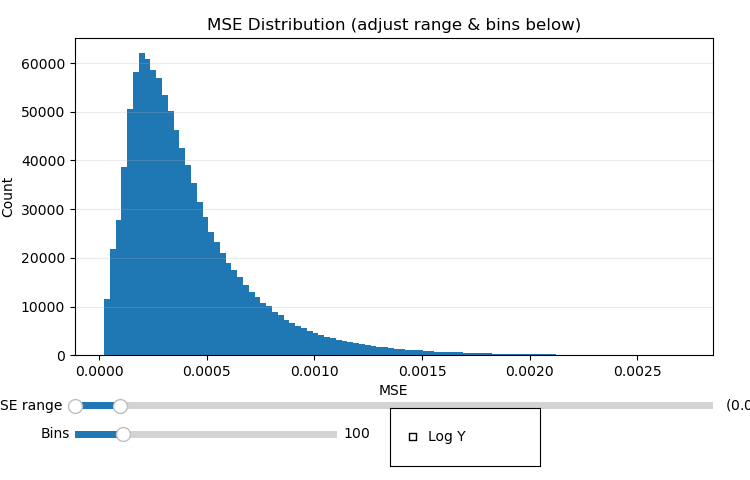

In [5]:
#| label: ae1m-mse-distribution

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, RangeSlider, CheckButtons

# Global bounds & a sensible initial view (clip extreme tails)
xmin, xmax = float(np.min(x)), float(np.max(x))
x0, x1 = np.quantile(x, [0.001, 0.999])  # focus range (0.1%..99.9%)

fig, ax = plt.subplots(figsize=(7.5, 4.8))
plt.subplots_adjust(left=0.10, right=0.95, top=0.92, bottom=0.26)

try:
    fig.canvas.manager.set_window_title("MSE Distribution — Interactive Histogram")
except Exception:
    pass

initial_bins = 100
hist = ax.hist(x[(x >= x0) & (x <= x1)], bins=initial_bins, edgecolor=None)
ax.set_xlabel("MSE")
ax.set_ylabel("Count")
ax.set_title("MSE Distribution (adjust range & bins below)")
ax.grid(axis="y", alpha=0.25)

# Controls
ax_range = plt.axes([0.10, 0.14, 0.85, 0.03])
rs = RangeSlider(ax_range, "MSE range", xmin, xmax, valinit=(x0, x1))

ax_bins = plt.axes([0.10, 0.08, 0.35, 0.03])
sb = Slider(ax_bins, "Bins", 10, 500, valinit=initial_bins, valstep=1)

ax_log = plt.axes([0.52, 0.03, 0.20, 0.12])
cb = CheckButtons(ax_log, ["Log Y"], [False])

def update(_=None):
    low, high = rs.val
    bins = int(sb.val)
    ax.cla()
    mask = (x >= low) & (x <= high)
    ax.hist(x[mask], bins=bins, edgecolor=None)
    ax.set_xlabel("MSE")
    ax.set_ylabel("Count")
    ax.set_title("MSE distribution")
    ax.grid(axis="y", alpha=0.25)
    if cb.get_status()[0]:
        ax.set_yscale("log")
    fig.canvas.draw_idle()

rs.on_changed(update)
sb.on_changed(update)
cb.on_clicked(update)
plt.show()